In [1]:
import polars as pl

features = ['timestamp', 'end_timestamp', 'ball_owning_team', 'player_id', 'coordinates_x', 'coordinates_y',
            'end_coordinates_x', 'end_coordinates_y', 'receiver_player_id', 'body_part_type', 'set_piece_type', 'result', 'success', 'is_under_pressure',
            'pass_type', 'duel_type', 'goalkeeper_type', 'match_id', 'period_id']  # <-- period_id added

def agg_event_features(events_df):
    pass_events_df = (
        events_df
        .filter(events_df['event_type'] == 'PASS')
        .select(features)
    )

    pass_events_df = pass_events_df.with_columns(
        # Pass duration
        (pl.col('end_timestamp') - pl.col('timestamp'))
        .dt.total_milliseconds()
        .cast(pl.Float32)
        .truediv(1000)
        .fill_null(0)
        .alias('pass_time'),

        # Pass distance (Euclidean)
        ((pl.col('end_coordinates_x') - pl.col('coordinates_x'))**2 +
         (pl.col('end_coordinates_y') - pl.col('coordinates_y'))**2)
            .sqrt()
            .fill_null(0)
            .alias('pass_distance'),

        # Under pressure flag
        pl.col("is_under_pressure")
            .cast(pl.Int64, strict=True)
            .fill_null(0)
            .alias("is_under_pressure_int"),

        # Pass success
        pl.col('success')
            .cast(pl.Int64, strict=True)
            .fill_null(0)
            .alias("success_int"),

        pl.col('is_under_pressure').fill_null(False),
    )

    # ── Infer attacking direction per team per match per period ──────────────
    # If a team's median pass x < 0.5 → they're attacking right → goal at (1.0, 0.5)
    # If a team's median pass x > 0.5 → they're attacking left  → goal at (0.0, 0.5)
    attacking_direction = (
        pass_events_df
        .group_by(['match_id', 'period_id', 'ball_owning_team'])
        .agg(pl.col('coordinates_x').median().alias('median_x'))
        .with_columns(
            pl.when(pl.col('median_x') < 0.5)
              .then(pl.lit(1.0))
              .otherwise(pl.lit(0.0))
              .alias('goal_x')
        )
        .select(['match_id', 'period_id', 'ball_owning_team', 'goal_x'])
    )

    pass_events_df = pass_events_df.join(
        attacking_direction,
        on=['match_id', 'period_id', 'ball_owning_team'],
        how='left'
    )

    # goal_y is always 0.5 (centre of goal)
    pass_events_df = pass_events_df.with_columns(
        pl.lit(0.5).alias('goal_y')
    )

    # ── Distances using the correct goal for each team ───────────────────────
    pass_events_df = pass_events_df.with_columns(
        ((pl.col('goal_x') - pl.col('coordinates_x'))**2 +
         (pl.col('goal_y') - pl.col('coordinates_y'))**2)
            .sqrt()
            .alias('start_dist_to_goal'),

        ((pl.col('goal_x') - pl.col('end_coordinates_x'))**2 +
         (pl.col('goal_y') - pl.col('end_coordinates_y'))**2)
            .sqrt()
            .alias('end_dist_to_goal'),
    )

    # ── Progressive flag ─────────────────────────────────────────────────────
    # Exclude passes already in the attacking box (x >= 0.85, y 0.225-0.775)
    # but flip the box check for teams attacking left (goal_x == 0.0)
    pass_events_df = pass_events_df.with_columns(
        (
            # Gained >= 25% of remaining distance to goal
            ((pl.col('start_dist_to_goal') - pl.col('end_dist_to_goal')) / pl.col('start_dist_to_goal') >= 0.25)
            .and_(pl.col('success_int') == 1)
            .and_(
                # Not already in the attacking penalty area
                ~(
                    pl.when(pl.col('goal_x') == 1.0)
                      .then(pl.col('coordinates_x') >= 0.85)
                      .otherwise(pl.col('coordinates_x') <= 0.15)  # mirrored for left-attacking
                )
                .and_(pl.col('coordinates_y').is_between(0.225, 0.775))
            )
        )
        .cast(pl.Int8)
        .alias('is_progressive')
    )

    return pass_events_df


matchs_df = pl.read_parquet('BL_23_24_match_events.parquet')
print(matchs_df.shape)
pass_events_df = matchs_df.filter(matchs_df['event_type'] == 'PASS')
pass_events_df = agg_event_features(pass_events_df)

(959521, 24)


In [1]:
import polars as pl

matchs_df = pl.read_parquet('BL_23_24_match_events.parquet')

matchs_df.head()

event_id,event_type,period_id,timestamp,end_timestamp,ball_state,ball_owning_team,team_id,player_id,coordinates_x,coordinates_y,end_coordinates_x,end_coordinates_y,receiver_player_id,body_part_type,set_piece_type,result,success,duel_type,is_under_pressure,pass_type,goalkeeper_type,match_id,card_type
str,str,i64,duration[μs],duration[μs],str,str,str,str,f64,f64,f64,f64,str,str,str,str,bool,str,bool,str,str,i32,str
"""4858179098""","""PASS""",1,0µs,332ms,"""alive""","""33""","""33""","""204""",0.5,0.5,null,null,null,"""RIGHT_FOOT""","""KICK_OFF""","""INCOMPLETE""",false,null,null,null,null,122838,null
"""4858179099""","""GENERIC:NO_VIDEO""",1,332ms,null,"""alive""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,122838,null
"""4858179100""","""GENERIC:RECEPTION""",1,1s 651ms,null,"""alive""","""33""","""33""","""1202""",0.20381,0.430882,null,null,null,null,null,null,null,null,null,null,null,122838,null
"""4858179101""","""CARRY""",1,1s 651100µs,4s 193ms,"""alive""","""33""","""33""","""1202""",0.20381,0.430882,0.205714,0.501471,null,"""RIGHT_FOOT""",null,"""COMPLETE""",true,null,null,null,null,122838,null
"""4858179102""","""PASS""",1,4s 192999µs,6s 904999µs,"""alive""","""33""","""33""","""1202""",0.205714,0.501471,0.627619,0.091176,null,"""RIGHT_FOOT""",null,"""INCOMPLETE""",false,null,null,null,null,122838,null


In [2]:
matchs_df.filter(pl.col('event_id').str.contains('122839'))

event_id,event_type,period_id,timestamp,end_timestamp,ball_state,ball_owning_team,team_id,player_id,coordinates_x,coordinates_y,end_coordinates_x,end_coordinates_y,receiver_player_id,body_part_type,set_piece_type,result,success,duel_type,is_under_pressure,pass_type,goalkeeper_type,match_id,card_type
str,str,i64,duration[μs],duration[μs],str,str,str,str,f64,f64,f64,f64,str,str,str,str,bool,str,bool,str,str,i32,str
"""4609122839""","""PASS""",2,11m 30s 342999µs,11m 31s 708999µs,"""alive""","""33""","""33""","""1053""",0.517143,0.222059,0.634286,0.075,"""53703""","""RIGHT_FOOT""",null,"""COMPLETE""",true,null,true,null,null,123063,null


X range: 0.0 - 1.0
Y range: 0.0 - 1.0


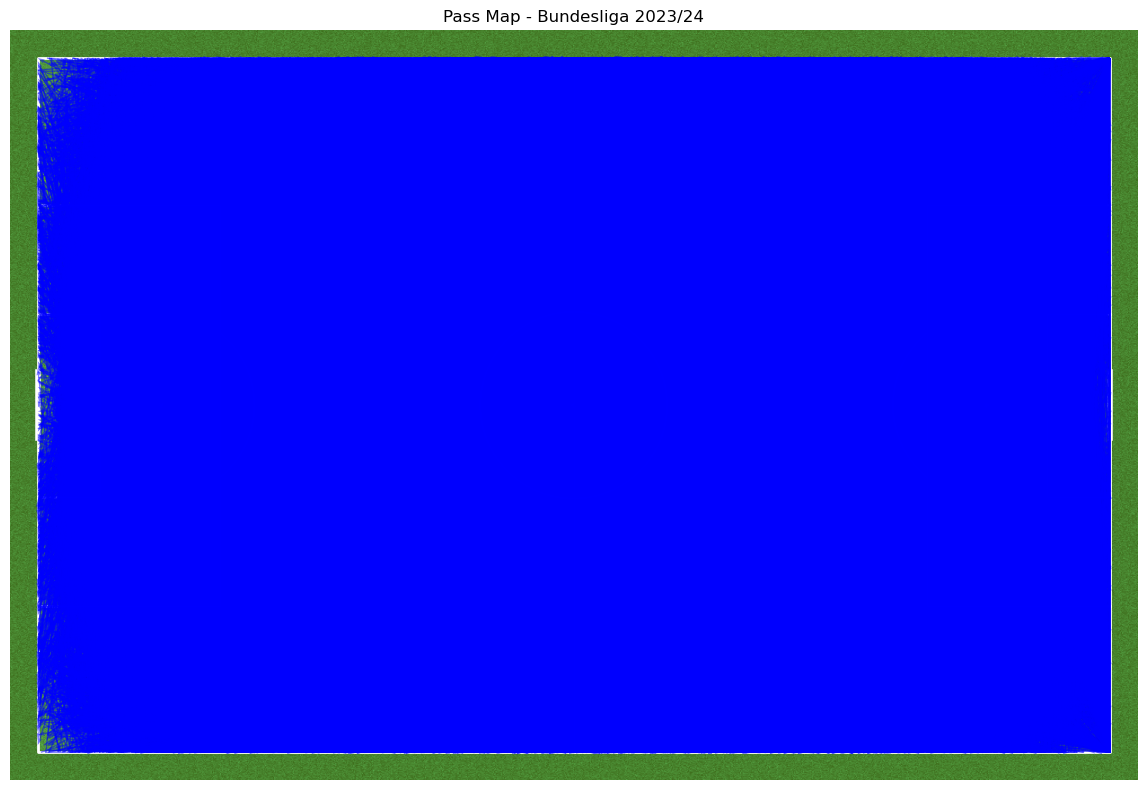

In [7]:
import polars as pl
import matplotlib.pyplot as plt
from mplsoccer import Pitch

# ...existing code...
matchs_df = pl.read_parquet('BL_23_24_match_events.parquet')

# Filter for pass events and remove nulls
passes = matchs_df.filter(
    (pl.col('event_type') == 'PASS') &
    (pl.col('coordinates_x').is_not_null()) &
    (pl.col('coordinates_y').is_not_null()) &
    (pl.col('end_coordinates_x').is_not_null()) &
    (pl.col('end_coordinates_y').is_not_null())
)

# Check coordinate ranges
print("X range:", passes['coordinates_x'].min(), "-", passes['coordinates_x'].max())
print("Y range:", passes['coordinates_y'].min(), "-", passes['coordinates_y'].max())

# Normalize coordinates to 0-100 if needed
passes = passes.with_columns([
    (pl.col('coordinates_x') * 100).alias('coordinates_x'),
    (pl.col('coordinates_y') * 100).alias('coordinates_y'),
    (pl.col('end_coordinates_x') * 100).alias('end_coordinates_x'),
    (pl.col('end_coordinates_y') * 100).alias('end_coordinates_y'),
])

# Create pitch
pitch = Pitch(pitch_type='opta', pitch_color='grass', line_color='white', stripe=True)
fig, ax = plt.subplots(figsize=(12, 8))
pitch.draw(ax=ax)

# Plot passes
pitch.arrows(
    passes['coordinates_x'].to_numpy(), 
    passes['coordinates_y'].to_numpy(),
    passes['end_coordinates_x'].to_numpy(), 
    passes['end_coordinates_y'].to_numpy(),
    ax=ax,
    width=1,
    headwidth=3,
    alpha=0.5,
    color='blue'
)

plt.title('Pass Map - Bundesliga 2023/24')
plt.tight_layout()
plt.show()

X range: 0.004761904761904762 - 1.0
Y range: 0.0 - 1.0


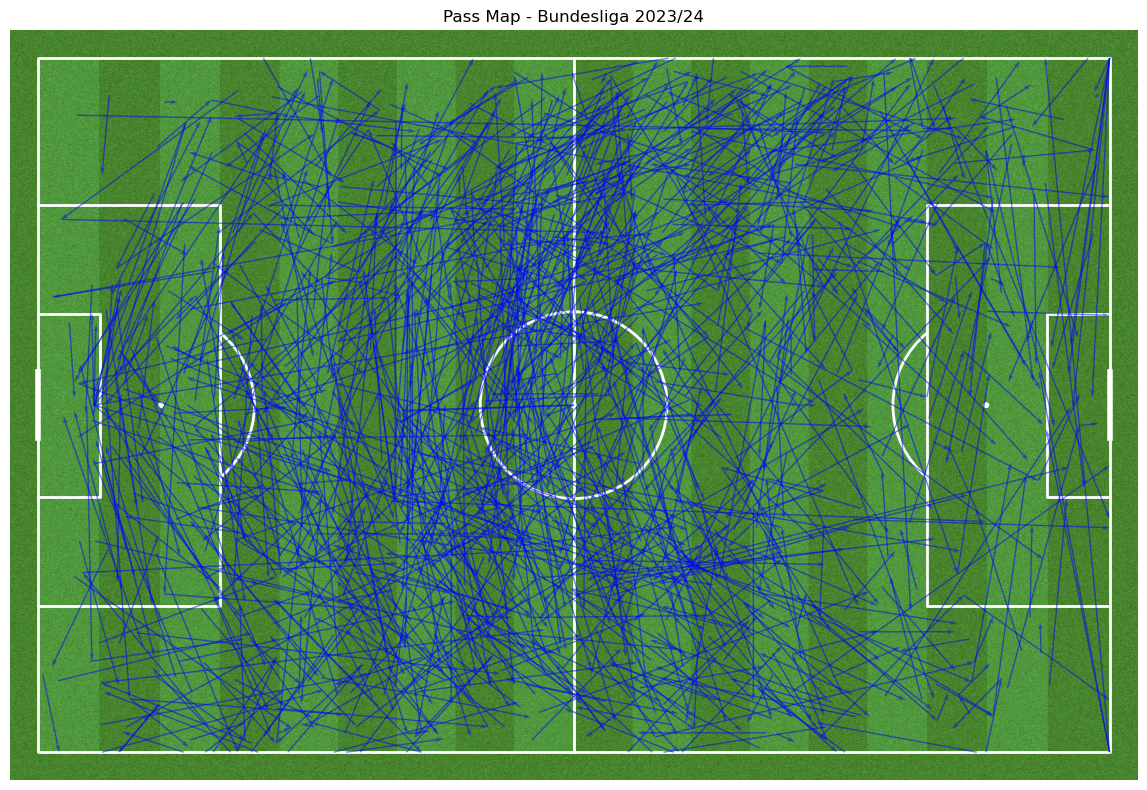

In [9]:
import polars as pl
import matplotlib.pyplot as plt
from mplsoccer import Pitch

# ...existing code...
matchs_df = pl.read_parquet('BL_23_24_match_events.parquet')

# Filter for pass events and remove nulls
passes = matchs_df.filter(
    (pl.col('event_type') == 'PASS') &
    (pl.col('match_id') == 122839) &
    (pl.col('coordinates_x').is_not_null()) &
    (pl.col('coordinates_y').is_not_null()) &
    (pl.col('end_coordinates_x').is_not_null()) &
    (pl.col('end_coordinates_y').is_not_null())
)

# Check coordinate ranges
print("X range:", passes['coordinates_x'].min(), "-", passes['coordinates_x'].max())
print("Y range:", passes['coordinates_y'].min(), "-", passes['coordinates_y'].max())

# Normalize coordinates to 0-100 if needed
passes = passes.with_columns([
    (pl.col('coordinates_x') * 100).alias('coordinates_x'),
    (pl.col('coordinates_y') * 100).alias('coordinates_y'),
    (pl.col('end_coordinates_x') * 100).alias('end_coordinates_x'),
    (pl.col('end_coordinates_y') * 100).alias('end_coordinates_y'),
])

# Create pitch
pitch = Pitch(pitch_type='opta', pitch_color='grass', line_color='white', stripe=True)
fig, ax = plt.subplots(figsize=(12, 8))
pitch.draw(ax=ax)

# Plot passes
pitch.arrows(
    passes['coordinates_x'].to_numpy(), 
    passes['coordinates_y'].to_numpy(),
    passes['end_coordinates_x'].to_numpy(), 
    passes['end_coordinates_y'].to_numpy(),
    ax=ax,
    width=1,
    headwidth=3,
    alpha=0.5,
    color='blue'
)

plt.title('Pass Map - Bundesliga 2023/24')
plt.tight_layout()
plt.show()

In [3]:
pass_events_df.head(10)

timestamp,end_timestamp,ball_owning_team,player_id,coordinates_x,coordinates_y,end_coordinates_x,end_coordinates_y,receiver_player_id,body_part_type,set_piece_type,result,success,is_under_pressure,pass_type,duel_type,goalkeeper_type,match_id,pass_time,pass_distance,start_dist_to_goal,end_dist_to_goal,is_under_pressure_int,success_int,is_progressive
duration[μs],duration[μs],str,str,f64,f64,f64,f64,str,str,str,str,bool,bool,str,str,str,i32,f32,f64,f64,f64,i64,i64,i8
0µs,332ms,"""33""","""204""",0.5,0.5,null,null,null,"""RIGHT_FOOT""","""KICK_OFF""","""INCOMPLETE""",false,false,null,null,null,122838,0.332,0.0,0.5,null,0,0,0
4s 192999µs,6s 904999µs,"""33""","""1202""",0.205714,0.501471,0.627619,0.091176,null,"""RIGHT_FOOT""",null,"""INCOMPLETE""",false,false,null,null,null,122838,2.712,0.588511,0.794287,0.552996,0,0,0
6s 905100µs,8s 260ms,"""33""","""1028""",0.372381,0.908824,0.308571,0.866176,"""13599""","""HEAD""",null,"""COMPLETE""",true,true,"""HEAD_PASS""",null,null,122838,1.354,0.076749,0.749028,0.782406,1,1,0
11s 740100µs,14s 175ms,"""33""","""50321""",0.409524,0.289706,0.408571,0.0,null,"""HEAD""",null,"""INCOMPLETE""",false,true,"""HEAD_PASS""",null,null,122838,2.434,0.289707,0.626806,0.77446,1,0,0
24s 350ms,25s 161ms,"""38""","""1028""",0.591429,1.0,0.626667,0.860294,"""9550""","""KEEPER_ARM""","""THROW_IN""","""COMPLETE""",true,false,"""HAND_PASS""",null,null,122838,0.811,0.144081,0.645702,0.518835,0,1,0
26s 204ms,29s 631ms,"""38""","""9550""",0.605714,0.916176,0.355238,0.898529,"""6201""","""RIGHT_FOOT""",null,"""COMPLETE""",true,true,null,null,null,122838,3.427,0.251097,0.573292,0.757987,1,1,0
30s 484ms,33s 117ms,"""38""","""6201""",0.310476,0.869118,0.090476,0.588235,"""8451""","""RIGHT_FOOT""",null,"""COMPLETE""",true,false,null,null,null,122838,2.633,0.356784,0.782107,0.913794,0,1,0
34s 368999µs,37s 326999µs,"""38""","""8451""",0.084762,0.638235,0.427619,0.916176,null,"""RIGHT_FOOT""",null,"""INCOMPLETE""",false,true,"""CHIPPED_PASS""",null,null,122838,2.958,0.441364,0.925619,0.707688,1,0,0
37s 327100µs,37s 782ms,"""38""","""32432""",0.572381,0.083824,0.610476,0.179412,null,"""HEAD""",null,"""INCOMPLETE""",false,true,"""HEAD_PASS""",null,null,122838,0.454,0.1029,0.596708,0.504485,1,0,0


In [15]:
pl.Config.set_tbl_rows(100)

pass_events_df.filter(pl.col('match_id') == 122839).head(20)

timestamp,end_timestamp,ball_owning_team,player_id,coordinates_x,coordinates_y,end_coordinates_x,end_coordinates_y,receiver_player_id,body_part_type,set_piece_type,result,success,is_under_pressure,pass_type,duel_type,goalkeeper_type,match_id,pass_time,pass_distance,start_dist_to_goal,end_dist_to_goal,is_under_pressure_int,success_int,is_progressive
duration[μs],duration[μs],str,str,f64,f64,f64,f64,str,str,str,str,bool,bool,str,str,str,i32,f32,f64,f64,f64,i64,i64,i8
0µs,2ms,"""37""","""2735""",0.5,0.5,0.472381,0.483824,"""5658""","""RIGHT_FOOT""","""KICK_OFF""","""COMPLETE""",true,false,null,null,null,122839,0.002,0.032008,0.5,0.527867,0,1,0
2100µs,697ms,"""37""","""5658""",0.472381,0.483824,0.460952,0.939706,"""1303""","""RIGHT_FOOT""",null,"""COMPLETE""",true,false,null,null,null,122839,0.694,0.456026,0.527867,0.695639,0,1,0
2s 21999µs,4s 331999µs,"""37""","""1303""",0.473333,0.942647,0.326667,0.776471,"""49763""","""RIGHT_FOOT""",null,"""COMPLETE""",true,false,null,null,null,122839,2.31,0.221643,0.687978,0.727883,0,1,0
5s 548ms,7s 58ms,"""37""","""49763""",0.305714,0.744118,0.266667,0.447059,"""1235""","""RIGHT_FOOT""",null,"""COMPLETE""",true,false,null,null,null,122839,1.51,0.299614,0.735952,0.735242,0,1,0
9s 521ms,10s 600ms,"""37""","""1235""",0.320952,0.419118,0.314286,0.639706,"""49763""","""RIGHT_FOOT""",null,"""COMPLETE""",true,false,null,null,null,122839,1.079,0.220689,0.683848,0.699801,0,1,0
11s 547ms,12s 843ms,"""37""","""49763""",0.327619,0.698529,0.42,0.954412,"""1303""","""RIGHT_FOOT""",null,"""COMPLETE""",true,false,null,null,null,122839,1.296,0.272048,0.701078,0.736811,0,1,0
15s 19999µs,16s 221999µs,"""37""","""1303""",0.472381,0.891176,0.658095,0.523529,"""5658""","""RIGHT_FOOT""",null,"""COMPLETE""",true,true,"""CHIPPED_PASS""",null,null,122839,1.202,0.411891,0.656811,0.342713,1,1,1
17s 365100µs,19s 94ms,"""37""","""49562""",0.211429,0.504412,0.280952,0.254412,null,"""RIGHT_FOOT""",null,"""INCOMPLETE""",false,true,null,null,null,122839,1.728,0.259487,0.788584,0.759831,1,0,0
19s 94100µs,20s 71ms,"""37""","""2735""",0.719048,0.745588,0.677143,0.404412,"""5658""","""RIGHT_FOOT""",null,"""COMPLETE""",true,true,null,null,null,122839,0.976,0.34374,0.373159,0.33671,1,1,0


In [ ]:
pass_events_df.columns

['timestamp',
 'end_timestamp',
 'ball_owning_team',
 'player_id',
 'coordinates_x',
 'coordinates_y',
 'end_coordinates_x',
 'end_coordinates_y',
 'receiver_player_id',
 'body_part_type',
 'set_piece_type',
 'result',
 'success',
 'is_under_pressure',
 'pass_type',
 'duel_type',
 'goalkeeper_type',
 'match_id',
 'pass_time',
 'pass_distance',
 'start_dist_to_goal',
 'end_dist_to_goal',
 'is_under_pressure_int',
 'success_int',
 'is_progressive']

In [ ]:
import polars as pl
import matplotlib
matplotlib.use('TkAgg')  # Use TkAgg backend for VS Code (or 'Qt5Agg' if you have PyQt5)
import matplotlib.pyplot as plt
from mplsoccer import Pitch

passes = pass_events_df.filter(
    (pl.col('match_id') == 122839) &
    (pl.col('coordinates_x').is_not_null()) &
    (pl.col('coordinates_y').is_not_null()) &
    (pl.col('end_coordinates_x').is_not_null()) &
    (pl.col('end_coordinates_y').is_not_null())
).head(20)

passes = passes.with_columns([
    (pl.col('coordinates_x') * 100).alias('coordinates_x'),
    (pl.col('coordinates_y') * 100).alias('coordinates_y'),
    (pl.col('end_coordinates_x') * 100).alias('end_coordinates_x'),
    (pl.col('end_coordinates_y') * 100).alias('end_coordinates_y'),
])

pitch = Pitch(pitch_type='opta')
fig, ax = plt.subplots(figsize=(12, 8))
plt.ion()  # Enable interactive mode instead of %matplotlib notebook

for i in range(len(passes)):
    ax.clear()
    pitch.draw(ax=ax)
    
    current_passes = passes.slice(0, i + 1)
    pitch.arrows(
        current_passes['coordinates_x'].to_numpy(), 
        current_passes['coordinates_y'].to_numpy(),
        current_passes['end_coordinates_x'].to_numpy(), 
        current_passes['end_coordinates_y'].to_numpy(),
        ax=ax,
        width=1,
        headwidth=3,
        alpha=0.5,
        color='blue'
    )
    
    ax.set_title(f'Pass Map - Pass {i + 1}/20')
    plt.draw()
    plt.pause(0.5)

plt.ioff()  # Disable interactive mode when done
plt.show()
print("Animation complete!")

KeyboardInterrupt: 

: 

In [3]:
import polars as pl
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from mplsoccer import Pitch

# ── FILTERS ────────────────────────────────────────────────────────────────
TEAM_FILTER        = None   # e.g. 'Bayern Munich' or None for all teams
SUCCESS_FILTER     = None   # 0, 1, or None
PROGRESSIVE_FILTER = None   # 0, 1, or None

SHOW_TEAM_HALO = True
# ──────────────────────────────────────────────────────────────────────────

SUCCESS_COLORS = {
    1: ('#2ecc71', 'Successful'),
    0: ('#e74c3c', 'Unsuccessful'),
}

# Progressive = bold thick arrow | Non-progressive = thin faint arrow
PROGRESSIVE_STYLE = {
    1: {'width': 2.5, 'headwidth': 5,   'alpha': 0.95},
    0: {'width': 0.8, 'headwidth': 2.5, 'alpha': 0.35},
}

TEAM_PALETTE = ['#f1c40f', '#00aaff', '#3498db', '#1abc9c', '#e67e22', '#ff69b4']

# ── Load & filter ──────────────────────────────────────────────────────────
filter_expr = (
    (pl.col('match_id') == 122839) &
    (pl.col('coordinates_x').is_not_null()) &
    (pl.col('coordinates_y').is_not_null()) &
    (pl.col('end_coordinates_x').is_not_null()) &
    (pl.col('end_coordinates_y').is_not_null())
)

if TEAM_FILTER is not None:
    filter_expr = filter_expr & (pl.col('ball_owning_team') == TEAM_FILTER)
if SUCCESS_FILTER is not None:
    filter_expr = filter_expr & (pl.col('success_int') == SUCCESS_FILTER)
if PROGRESSIVE_FILTER is not None:
    filter_expr = filter_expr & (pl.col('is_progressive') == PROGRESSIVE_FILTER)

# passes = pass_events_df.filter(filter_expr).head(200)
passes = pass_events_df.filter(filter_expr).slice(39, 25)

passes = passes.with_columns([
    (pl.col('coordinates_x') * 100).alias('coordinates_x'),
    (pl.col('coordinates_y') * 100).alias('coordinates_y'),
    (pl.col('end_coordinates_x') * 100).alias('end_coordinates_x'),
    (pl.col('end_coordinates_y') * 100).alias('end_coordinates_y'),
])

# ── Team colors ────────────────────────────────────────────────────────────
teams = passes['ball_owning_team'].drop_nulls().unique().to_list()
TEAM_COLORS = {team: TEAM_PALETTE[i % len(TEAM_PALETTE)] for i, team in enumerate(sorted(teams))}

# ── Helpers ────────────────────────────────────────────────────────────────
def get_arrow_color(df, j):
    val = df['success_int'][j]
    return SUCCESS_COLORS.get(val, ('#aaaaaa', 'Unknown'))[0]

def get_arrow_style(df, j):
    val = df['is_progressive'][j]
    return PROGRESSIVE_STYLE.get(val, PROGRESSIVE_STYLE[0])

def get_team_color(df, j):
    return TEAM_COLORS.get(df['ball_owning_team'][j], '#cccccc')

def build_legend():
    handles = []
    for val, (color, label) in SUCCESS_COLORS.items():
        handles.append(Patch(facecolor=color, label=label))
    handles.append(plt.Line2D([0], [0], color='gray', linewidth=3,  label='Progressive (bold)'))
    handles.append(plt.Line2D([0], [0], color='gray', linewidth=1,  alpha=0.4, label='Non-progressive (faint)'))
    if SHOW_TEAM_HALO:
        for team, color in TEAM_COLORS.items():
            handles.append(Patch(facecolor=color, alpha=0.4, label=f'Team: {team}'))
    return handles

# ── Animate ────────────────────────────────────────────────────────────────
pitch = Pitch(pitch_type='opta')
fig, ax = plt.subplots(figsize=(12, 8))
plt.ion()

for i in range(len(passes)):
    ax.clear()
    pitch.draw(ax=ax)

    current_passes = passes.slice(0, i + 1)

    for j in range(len(current_passes)):
        x  = [current_passes['coordinates_x'][j]]
        y  = [current_passes['coordinates_y'][j]]
        ex = [current_passes['end_coordinates_x'][j]]
        ey = [current_passes['end_coordinates_y'][j]]

        style = get_arrow_style(current_passes, j)
        color = get_arrow_color(current_passes, j)

        # 1. Team halo — scales with arrow thickness so it always peeks out
        if SHOW_TEAM_HALO:
            pitch.arrows(x, y, ex, ey, ax=ax,
                         width=style['width'] + 3.5,
                         headwidth=style['headwidth'] + 4,
                         alpha=0.2,
                         color=get_team_color(current_passes, j),
                         zorder=2)

        # 2. Main arrow on top
        pitch.arrows(x, y, ex, ey, ax=ax,
                     width=style['width'],
                     headwidth=style['headwidth'],
                     alpha=style['alpha'],
                     color=color,
                     zorder=3)

    ax.legend(handles=build_legend(), loc='upper right', framealpha=0.85, fontsize=8)

    filter_summary = ' | '.join(filter(None, [
        f"Team: {TEAM_FILTER}" if TEAM_FILTER else None,
        f"Success: {SUCCESS_FILTER}" if SUCCESS_FILTER is not None else None,
        f"Progressive: {PROGRESSIVE_FILTER}" if PROGRESSIVE_FILTER is not None else None,
    ])) or 'No filters'

    ax.set_title(
        f'Pass Map — Pass {i + 1}/{len(passes)}\n'
        f'Color: success  |  Thickness: progressive  |  Halo: team  |  Filters: {filter_summary}',
        fontsize=10
    )

    plt.draw()
    plt.pause(0.5)

plt.ioff()
plt.show()
print("Animation complete!")

: 

In [2]:
import polars as pl
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.patches import Patch
from mplsoccer import Pitch

# ── FILTERS ────────────────────────────────────────────────────────────────
TEAM_FILTER        = None
SUCCESS_FILTER     = None
PROGRESSIVE_FILTER = None
SHOW_TEAM_HALO     = True

GIF_PATH    = 'pass_map.gif'
INTERVAL_MS = 500   # milliseconds between frames
# ──────────────────────────────────────────────────────────────────────────

SUCCESS_COLORS = {
    1: ('#2ecc71', 'Successful'),
    0: ('#e74c3c', 'Unsuccessful'),
}
PROGRESSIVE_STYLE = {
    1: {'width': 2.5, 'headwidth': 5,   'alpha': 0.95},
    0: {'width': 0.8, 'headwidth': 2.5, 'alpha': 0.35},
}
TEAM_PALETTE = ['#f1c40f', '#00aaff', '#3498db', '#1abc9c', '#e67e22', '#ff69b4']

# ── Load & filter ──────────────────────────────────────────────────────────
filter_expr = (
    (pl.col('match_id') == 122839) &
    (pl.col('coordinates_x').is_not_null()) &
    (pl.col('coordinates_y').is_not_null()) &
    (pl.col('end_coordinates_x').is_not_null()) &
    (pl.col('end_coordinates_y').is_not_null())
)
if TEAM_FILTER is not None:
    filter_expr = filter_expr & (pl.col('ball_owning_team') == TEAM_FILTER)
if SUCCESS_FILTER is not None:
    filter_expr = filter_expr & (pl.col('success_int') == SUCCESS_FILTER)
if PROGRESSIVE_FILTER is not None:
    filter_expr = filter_expr & (pl.col('is_progressive') == PROGRESSIVE_FILTER)

passes = pass_events_df.filter(filter_expr).slice(39, 25)

passes = passes.with_columns([
    (pl.col('coordinates_x') * 100).alias('coordinates_x'),
    (pl.col('coordinates_y') * 100).alias('coordinates_y'),
    (pl.col('end_coordinates_x') * 100).alias('end_coordinates_x'),
    (pl.col('end_coordinates_y') * 100).alias('end_coordinates_y'),
])

teams = passes['ball_owning_team'].drop_nulls().unique().to_list()
TEAM_COLORS = {team: TEAM_PALETTE[i % len(TEAM_PALETTE)] for i, team in enumerate(sorted(teams))}

# ── Helpers ────────────────────────────────────────────────────────────────
def get_arrow_color(df, j):
    val = df['success_int'][j]
    return SUCCESS_COLORS.get(val, ('#aaaaaa', 'Unknown'))[0]

def get_arrow_style(df, j):
    return PROGRESSIVE_STYLE.get(df['is_progressive'][j], PROGRESSIVE_STYLE[0])

def get_team_color(df, j):
    return TEAM_COLORS.get(df['ball_owning_team'][j], '#cccccc')

def build_legend():
    handles = []
    for val, (color, label) in SUCCESS_COLORS.items():
        handles.append(Patch(facecolor=color, label=label))
    handles.append(plt.Line2D([0], [0], color='gray', linewidth=3, label='Progressive (bold)'))
    handles.append(plt.Line2D([0], [0], color='gray', linewidth=1, alpha=0.4, label='Non-progressive (faint)'))
    if SHOW_TEAM_HALO:
        for team, color in TEAM_COLORS.items():
            handles.append(Patch(facecolor=color, alpha=0.4, label=f'Team: {team}'))
    return handles

# ── Build animation ────────────────────────────────────────────────────────
pitch = Pitch(pitch_type='opta')
fig, ax = plt.subplots(figsize=(12, 8))

def draw_frame(i):
    ax.clear()
    pitch.draw(ax=ax)

    current_passes = passes.slice(0, i + 1)

    for j in range(len(current_passes)):
        x  = [current_passes['coordinates_x'][j]]
        y  = [current_passes['coordinates_y'][j]]
        ex = [current_passes['end_coordinates_x'][j]]
        ey = [current_passes['end_coordinates_y'][j]]
        style = get_arrow_style(current_passes, j)
        color = get_arrow_color(current_passes, j)

        if SHOW_TEAM_HALO:
            pitch.arrows(x, y, ex, ey, ax=ax,
                         width=style['width'] + 3.5,
                         headwidth=style['headwidth'] + 4,
                         alpha=0.2,
                         color=get_team_color(current_passes, j),
                         zorder=2)
        pitch.arrows(x, y, ex, ey, ax=ax,
                     width=style['width'],
                     headwidth=style['headwidth'],
                     alpha=style['alpha'],
                     color=color,
                     zorder=3)

    ax.legend(handles=build_legend(), loc='upper right', framealpha=0.85, fontsize=8)

    filter_summary = ' | '.join(filter(None, [
        f"Team: {TEAM_FILTER}" if TEAM_FILTER else None,
        f"Success: {SUCCESS_FILTER}" if SUCCESS_FILTER is not None else None,
        f"Progressive: {PROGRESSIVE_FILTER}" if PROGRESSIVE_FILTER is not None else None,
    ])) or 'No filters'

    ax.set_title(
        f'Pass Map — Pass {i + 1}/{len(passes)}\n'
        f'Color: success  |  Thickness: progressive  |  Halo: team  |  Filters: {filter_summary}',
        fontsize=10
    )

anim = animation.FuncAnimation(
    fig,
    draw_frame,
    frames=len(passes),
    interval=INTERVAL_MS,
    repeat=False
)

print(f"Saving GIF to {GIF_PATH} ...")
anim.save(GIF_PATH, writer='pillow', fps=1000 // INTERVAL_MS, dpi=120)
print("Done!")
plt.close(fig)

Saving GIF to pass_map.gif ...
Done!
